In [1]:
from pathlib import Path
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from data.img_seq_generator import ImageSequenceDataGenerator, MultiSequenceGenerator

In [2]:
ELAR_TEST_CSV = Path(r'D:\Uni\Honours\Project\data\elar\test_labels_10classes.csv')
AUTSL_TEST_CSV = Path(r'D:\Uni\Honours\Project\data\autsl\test_labels_20classes.csv')
AUTSL_MODEL_PATH = Path(r'D:\Uni\Honours\Project\data\autsl\outputs\runs\training_rgb_042.best.hdf5')
AUTSL_MODEL_2_PATH = Path(r'D:\Uni\Honours\Project\data\autsl\outputs\runs\multi_182.best.hdf5')
ELAR_MODEL_PATH = Path(r'D:\Uni\Honours\Project\data\elar\outputs\runs\training_rgb_140.best.hdf5')
ELAR_MODEL_2_PATH = Path(r'D:\Uni\Honours\Project\data\elar\outputs\runs\multi_156.best.hdf5')

# Data
AUTSL_RGB_DATA = Path(r'D:\Uni\Honours\Project\data\autsl\frames_rgb_20', 'test')
AUTSL_POSE_DATA = Path(r'D:\Uni\Honours\Project\data\autsl\frames_full_landmarks_bg_20', 'test')
ELAR_RGB_DATA = Path(r'D:\Uni\Honours\Project\data\elar\frames_rgb_10', 'test')
ELAR_LANDMARKS_DATA = Path(r'D:\Uni\Honours\Project\data\elar\frames_landmarks_conf25_10', 'test')
ELAR_POSE_DATA = Path(r'D:\Uni\Honours\Project\data\elar\frames_full_landmarks_bg_10', 'test')

In [3]:
elar_df = pd.read_csv(ELAR_TEST_CSV)
elar_df.head()

,id,Sample,EN
0,0,BMKB2c7a_boy_af357bff,boy
1,1,BGMQB2c7a_boy1_f0dd2718,boy
2,2,SGMB2c7a_boy_4ab2eead,boy
3,3,BCHA2c7a_boy_89b64016,boy
4,4,MVSB3c9a_boy_a7bd797f,boy


In [4]:
autsl_df = pd.read_csv(AUTSL_TEST_CSV)
autsl_df.head()

,Unnamed: 0,Sample,ClassId,EN
0,30,signer34_sample31,86,no
1,34,signer34_sample35,13,key
2,50,signer34_sample51,120,dog
3,68,signer34_sample69,126,scissors
4,78,signer34_sample79,22,look


In [5]:
elar_true_labels = elar_df['EN']
elar_classes = np.unique(elar_true_labels)
elar_classes

array(['boy', 'dog', 'frog', 'good', 'have', 'look', 'one', 'people',
       'tortoise', 'wolf'], dtype=object)

In [6]:
elar_true_label_indices = [np.where(elar_classes == label)[0] for label in elar_true_labels]
# elar_true_label_indices
print(f"True label indice for first sample, 'boy': {elar_true_label_indices[0]}")
print(f"Class label = {elar_classes[elar_true_label_indices[0]]}")

True label indice for first sample, 'boy': [0]
Class label = ['boy']


In [7]:
autsl_true_labels = autsl_df['EN']
autsl_classes = np.unique(autsl_true_labels)
autsl_classes

array(['apologize', 'breakfast', 'congratulations', 'dog', 'eat',
       'friend', 'garden', 'hurry', 'ill', 'key', 'look', 'money', 'no',
       'okay', 'pillow', 'room', 'scissors', 'tea', 'umbrella', 'wedding'],
      dtype=object)

In [8]:
autsl_true_label_indices = [np.where(autsl_classes == label)[0] for label in autsl_true_labels]
# autsl_true_label_indices
print(f"True label indice for first sample, 'no': {autsl_true_label_indices[0]}")
print(f"Class label = {autsl_classes[autsl_true_label_indices[0]]}")

True label indice for first sample, 'no': [12]
Class label = ['no']


In [9]:
# HELPERS
def make_confusion_matrix(true_labels, predictions, classes, figname):
    # Confusion Matrix
    cm = confusion_matrix(true_labels[:predictions.shape[0]], predictions)
    plt.figure(figsize=(16,10))

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='viridis')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'{figname} Confusion Matrix')
    ax.xaxis.set_ticklabels(classes, rotation=45)
    ax.yaxis.set_ticklabels(classes, rotation=360)
    plt.savefig(f"{figname}_cm.jpg", dpi=300)
    plt.show()
    
def show_image_seq(img_sequence):
    n = img_sequence.shape[0]
    fig = plt.figure(figsize=(8,8))
    r = int(n**.5)
    c = int(np.ceil(n/r))
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(img_sequence[i]/255.)
    plt.axis('off')
    plt.show()
    
def top_n_accuracy(preds, truths, n):
    best_n = np.argsort(preds, axis=1)[:,-n:]
    ts = truths[:preds.shape[0]]
    successes = 0
    for i in range(len(ts)):
        if ts[i] in best_n[i,:]:
            successes += 1
    return float(successes)/len(ts)

# AUTSL
## RGB Model

In [34]:
autsl_model = tf.keras.models.load_model(AUTSL_MODEL_PATH)
autsl_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, 224, 224, 3 0         
_________________________________________________________________
EfficientNetB0 (TimeDistribu (None, None, 7, 7, 1280)  4049571   
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1280)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               3672064   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1026

In [35]:
batch = 8
input_size = (224, 224, 3)
autsl_rgb_gen = ImageSequenceDataGenerator(autsl_df, str(AUTSL_RGB_DATA), batch_size=batch, input_size=input_size, shuffle=False)
# autsl_depth_gen = ImageSequenceDataGenerator(autsl_df, str(AUTSL_DEPTH_DATA), batch_size=batch, input_size=input_size, shuffle=False)
# autsl_multi_gen = MultiSequenceGenerator(autsl_df, [autsl_rgb_gen, autsl_depth_gen], shuffle=False)

In [36]:
# Evaluate model
predictions = autsl_model.predict(autsl_rgb_gen, batch_size=batch, verbose=1)

41/41 [==============================] - 53s 1s/step


In [37]:
top_1_predictions = np.argmax(predictions, axis=1)
top_1_report = classification_report(autsl_true_label_indices[:top_1_predictions.shape[0]], top_1_predictions, target_names=autsl_classes)
print(top_1_report)

                 precision    recall  f1-score   support

      apologize       0.33      0.47      0.39        17
      breakfast       0.31      0.24      0.27        17
congratulations       0.12      0.14      0.13        14
            dog       0.36      0.24      0.29        17
            eat       0.37      0.41      0.39        17
         friend       0.16      0.73      0.26        15
         garden       0.52      0.71      0.60        17
          hurry       0.20      0.19      0.19        16
            ill       0.48      0.71      0.57        17
            key       0.14      0.06      0.09        16
           look       0.24      0.29      0.26        17
          money       0.07      0.06      0.06        16
             no       0.33      0.06      0.11        16
           okay       1.00      0.31      0.48        16
         pillow       0.61      0.65      0.63        17
           room       0.18      0.12      0.14        17
       scissors       0.27    

In [38]:
top_n_accuracy(predictions, autsl_true_label_indices, 5)

0.7652439024390244

In [39]:
top_n_accuracy(predictions, autsl_true_label_indices, 3)

0.5853658536585366

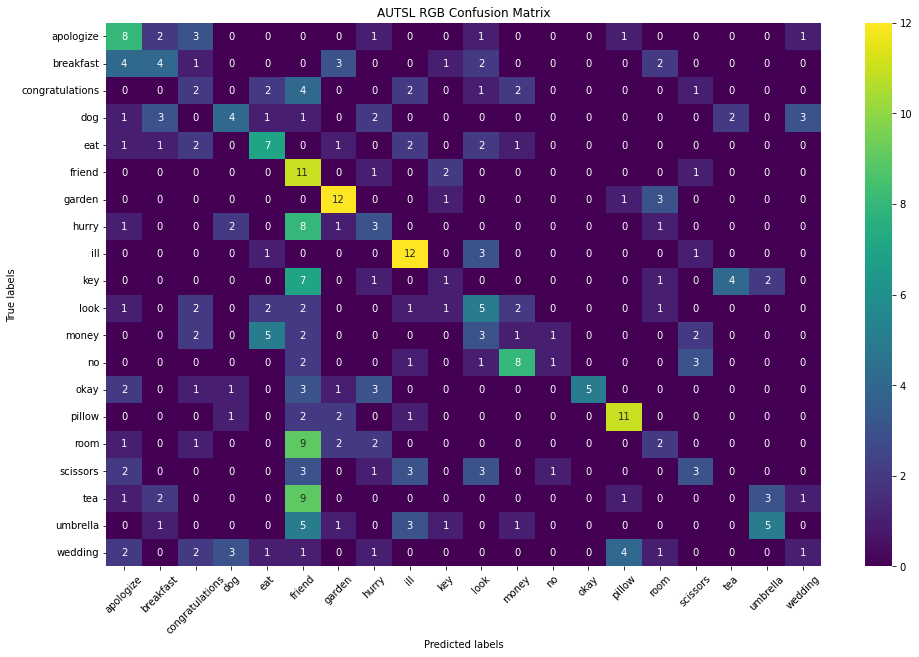

In [40]:
make_confusion_matrix(autsl_true_label_indices, top_1_predictions, autsl_classes, "AUTSL RGB")

## AUTSL RGB + POSE

In [10]:
autsl_model = tf.keras.models.load_model(AUTSL_MODEL_2_PATH)
autsl_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rgb Input (InputLayer)          [(None, None, 224, 2 0                                            
__________________________________________________________________________________________________
landmarks Input (InputLayer)    [(None, None, 224, 2 0                                            
__________________________________________________________________________________________________
EfficientNetB0_rgb (TimeDistrib (None, None, 7, 7, 1 4049571     rgb Input[0][0]                  
__________________________________________________________________________________________________
EfficientNetB0_landmarks (TimeD (None, None, 7, 7, 1 4049571     landmarks Input[0][0]            
____________________________________________________________________________________________

In [13]:
batch = 2
input_size = (224, 224, 3)
autsl_rgb_gen = ImageSequenceDataGenerator(autsl_df, str(AUTSL_RGB_DATA), batch_size=batch, input_size=input_size, shuffle=False)
autsl_pose_gen = ImageSequenceDataGenerator(autsl_df, str(AUTSL_POSE_DATA), batch_size=batch, input_size=input_size, shuffle=False)
autsl_multi_gen = MultiSequenceGenerator(autsl_df, [autsl_rgb_gen, autsl_pose_gen], shuffle=False)

In [14]:
# Evaluate model
predictions = autsl_model.predict(autsl_multi_gen, batch_size=batch, verbose=1)

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_1/EfficientNetB0_rgb/efficientnetb0/stem_conv/Conv2D (defined at <ipython-input-12-bf249316fee7>:2) ]] [Op:__inference_predict_function_21482]

Function call stack:
predict_function


In [53]:
top_1_predictions = np.argmax(predictions, axis=1)
top_1_report = classification_report(autsl_true_label_indices[:top_1_predictions.shape[0]], top_1_predictions, target_names=autsl_classes)
print(top_1_report)

                 precision    recall  f1-score   support

      apologize       0.00      0.00      0.00        17
      breakfast       0.05      0.06      0.06        17
congratulations       0.11      0.36      0.17        14
            dog       0.00      0.00      0.00        17
            eat       0.13      0.12      0.12        17
         friend       1.00      0.07      0.12        15
         garden       0.09      0.53      0.15        17
          hurry       0.00      0.00      0.00        16
            ill       0.33      0.47      0.39        17
            key       0.12      0.06      0.08        16
           look       0.00      0.00      0.00        17
          money       0.20      0.19      0.19        16
             no       0.00      0.00      0.00        16
           okay       0.00      0.00      0.00        16
         pillow       0.31      0.65      0.42        17
           room       0.67      0.12      0.20        17
       scissors       0.12    

c:\users\new user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\new user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\new user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [54]:
top_n_accuracy(predictions, autsl_true_label_indices, 5)

0.49085365853658536

In [55]:
top_n_accuracy(predictions, autsl_true_label_indices, 3)

0.3475609756097561

In [ ]:
make_confusion_matrix(autsl_true_label_indices, top_1_predictions, autsl_classes, "AUTSL POSE")

# ELAR
## RGB + POSE

In [13]:
elar_model = tf.keras.models.load_model(ELAR_MODEL_2_PATH)
elar_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rgb Input (InputLayer)          [(None, None, 224, 2 0                                            
__________________________________________________________________________________________________
landmarks Input (InputLayer)    [(None, None, 224, 2 0                                            
__________________________________________________________________________________________________
EfficientNetB0_rgb (TimeDistrib (None, None, 7, 7, 1 4049571     rgb Input[0][0]                  
__________________________________________________________________________________________________
EfficientNetB0_landmarks (TimeD (None, None, 7, 7, 1 4049571     landmarks Input[0][0]            
______________________________________________________________________________________________

In [14]:
batch = 8
input_size = (224, 224, 3)
elar_rgb_gen = ImageSequenceDataGenerator(elar_df, str(ELAR_RGB_DATA), batch_size=batch, input_size=input_size, shuffle=False)
elar_pose_gen = ImageSequenceDataGenerator(elar_df, str(ELAR_POSE_DATA), batch_size=batch, input_size=input_size, shuffle=False)
elar_multi_gen = MultiSequenceGenerator(elar_df, [elar_rgb_gen, elar_pose_gen], shuffle=False)

In [15]:
# Evaluate model
elar_predictions = elar_model.predict(elar_multi_gen, batch_size=batch, verbose=1)

47/47 [==============================] - 89s 2s/step


In [16]:
elar_top_1_predictions = np.argmax(elar_predictions, axis=1)
elar_top_1_report = classification_report(elar_true_label_indices[:elar_top_1_predictions.shape[0]], elar_top_1_predictions, target_names=elar_classes)
print(elar_top_1_report)

              precision    recall  f1-score   support

         boy       0.63      0.65      0.64        81
         dog       0.64      0.60      0.62        42
        frog       0.50      0.31      0.38        29
        good       0.50      0.42      0.45        24
        have       0.43      0.32      0.37        31
        look       0.59      0.64      0.62        73
         one       0.40      0.56      0.47        18
      people       0.45      0.62      0.52        21
    tortoise       0.85      0.88      0.86        32
        wolf       0.58      0.60      0.59        25

    accuracy                           0.59       376
   macro avg       0.56      0.56      0.55       376
weighted avg       0.58      0.59      0.58       376



In [18]:
top_n_accuracy(elar_predictions, elar_true_label_indices, 5)

0.9547872340425532

In [19]:
top_n_accuracy(elar_predictions, elar_true_label_indices, 3)

0.875

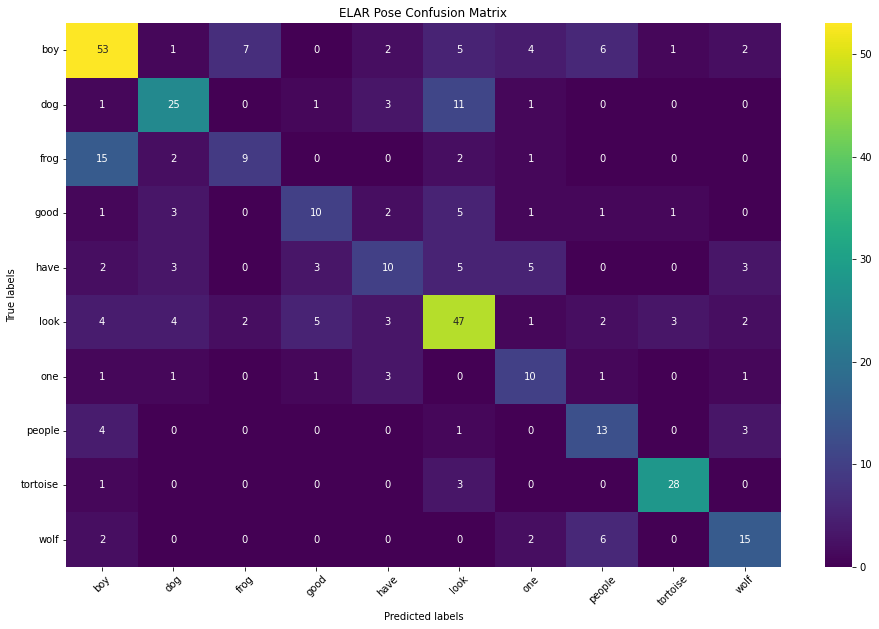

In [20]:
make_confusion_matrix(elar_true_label_indices, elar_top_1_predictions, elar_classes, "ELAR Pose")

## Using just RGB

In [23]:
elar_model2 = tf.keras.models.load_model(ELAR_MODEL_PATH)
elar_model2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, None, 224, 224, 3 0         
_________________________________________________________________
EfficientNetB0 (TimeDistribu (None, None, 7, 7, 1280)  4049571   
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 1280)        0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 512)               3672064   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130

In [24]:
batch = 8
input_size = (224, 224, 3)
elar_rgb_gen = ImageSequenceDataGenerator(elar_df, str(ELAR_RGB_DATA), batch_size=batch, input_size=input_size, shuffle=False)

In [25]:
# Evaluate model
predictions = elar_model2.predict(elar_rgb_gen, batch_size=batch, verbose=1)

47/47 [==============================] - 13s 194ms/step


In [26]:
elar_top_1_predictions = np.argmax(predictions, axis=1)
elar_top_1_report = classification_report(elar_true_label_indices[:elar_top_1_predictions.shape[0]], elar_top_1_predictions, target_names=elar_classes)
print(elar_top_1_report)

              precision    recall  f1-score   support

         boy       0.50      0.73      0.59        81
         dog       0.50      0.62      0.55        42
        frog       0.38      0.17      0.24        29
        good       0.50      0.08      0.14        24
        have       0.42      0.45      0.44        31
        look       0.51      0.41      0.45        73
         one       1.00      0.28      0.43        18
      people       0.33      0.19      0.24        21
    tortoise       0.86      0.94      0.90        32
        wolf       0.50      0.88      0.64        25

    accuracy                           0.52       376
   macro avg       0.55      0.48      0.46       376
weighted avg       0.53      0.52      0.49       376



In [27]:
top_n_accuracy(predictions, elar_true_label_indices, 3)

0.8617021276595744

In [28]:
top_n_accuracy(predictions, elar_true_label_indices, 5)

0.9574468085106383

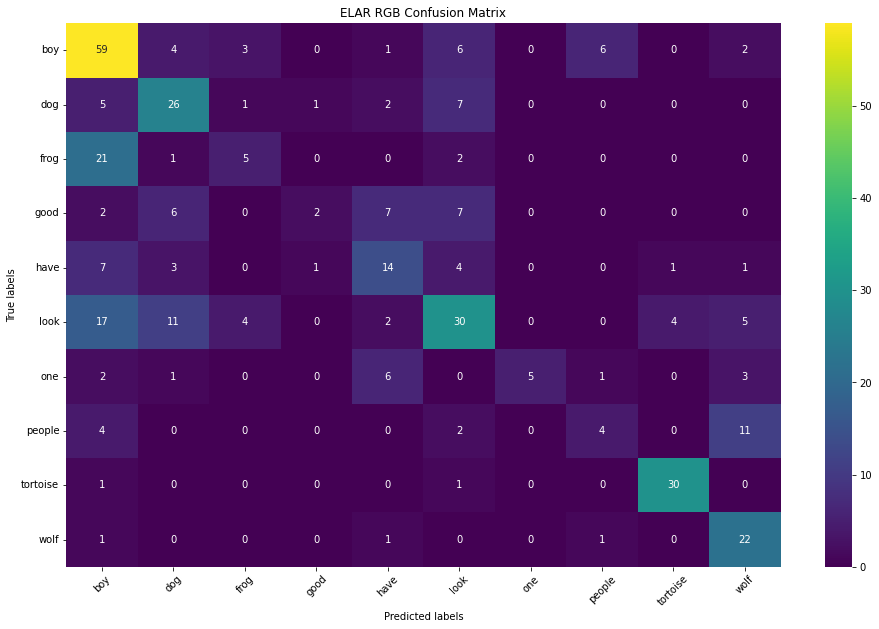

In [29]:
make_confusion_matrix(elar_true_label_indices, elar_top_1_predictions, elar_classes, "ELAR RGB")